## Data Ingestion

In [1]:
!pip install -qU langchain-text-splitters
!pip install unstructured
!pip install pdfminer.six
!python3 -m pip install pillow-heif

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.1.20 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.2.18 which is incompatible.
langchain 0.1.20 requires langchain-text-splitters<0.1,>=0.0.1, but you have langchain-text-splitters 0.2.2 which is incompatible.
ragatouille 0.0.8.post2 requires langchain_core<0.2.0,>=0.1.4, but you have langchain-core 0.2.18 which is incompatible.
  Using cached pillow_heif-0.17.0.tar.gz (14.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pillow-heif (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating buil

In [2]:
import os
from typing import List
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

from pyprojroot import here
import warnings; warnings.filterwarnings("ignore")
import time

%load_ext autoreload
%autoreload 2

In [3]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=here(".env"))

True

In [4]:
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")
os.environ["OPENAI_API_KEY"] = api_key

Setting Prompts for LLM

In [21]:
system_prompt = """You are the The Best Financial Research Analyst. \
    You are expert in analyzing financial statements, forecasting financial performance, \
    valuing the company, assessing investment opportunities and preparing research reports. \
    You will recieve a chat history, retrieved content from the vectorDB based on the user's question, and the source.\ 
    Your task is to respond to the user's question using the information \
    from the vectorDB and Chat history, without relying on your own knowledge. \
    Your output should contain only your response, and if you can't find relevant context say that you don't know. \
    You will receive a input prompt enclosed in triple backtics:

    # Retrieved content number:\n
    Content\n\n
    Source\n\n

    # User question:\n
    New question: 
    """
# order of difficulty
message = "Who is the CEO of Alphabet Inc?"
message1 = "What is the Commission file number on Alphabet's report?" #001-37580 
message2 = "What was the balance at Beginning at Year December 31, 2021 for Alphabet?" #USD 1,344 | pg 91
message4 = "What was the Total Fees Billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA?" # [NVIDIA: USD 8,308,800 |pg 68]
message3 = "What was the balance at End at Year December 31, 2021 for Alphabet and by what margin did the Revenue increased $13.6 billion for Microsoft in 2023 compare to fiscal 2022?" #[GOOGL: USD 1,389 | pg 91] [MSFT: 7% | pg31]

In [42]:
# settings for models and other config

llm_model="gpt-3.5-turbo"
temperature = 0.2
embeddings = OpenAIEmbeddings()

# Setting up Directory Paths, Loading and processing docs

In [23]:

# Replace these with your actual paths
directory_path = here("data/docs")

In [24]:
def load_docs(directory_path):
    """Loads all PDF files from the directory and splits them into chunks."""
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith(".pdf")]
    print("Number of PDF files:", len(pdf_files))
    
    docs = []
    document_file_paths = []  # Initialize the list to store file paths
    
    for pdf_file in pdf_files:
        file_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(file_path)
        docs.extend(loader.load())
        document_file_paths.append(file_path)  # Add the file path to the list
    
    print("Number of documents:", len(docs))

    return docs, document_file_paths

In [18]:
doc_pages, doc_file_paths =load_docs(directory_path)

Number of PDF files: 3
Number of documents: 351


In [44]:
import matplotlib.pyplot as plt

def split_documentsRCTS(docs: List, chunk_size: int = 1000, chunk_overlap: int = 200):
    """Splits documents into chunks of specified size."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunked_documents = text_splitter.split_documents(docs)
    len_chunk = []
    for chunk in chunked_documents:
        len_chunk.append(len(chunk.page_content))
    return chunked_documents, len_chunk

def plot_chunks(len_chunk, heading):
    plt.figure(figsize=(10, 5))
    plt.hist(len_chunk, bins=100)
    plt.title(heading)
    
    # Calculate min and max values of len_chunk
    min_len = min(len_chunk)
    max_len = max(len_chunk)
    
    # Define the box properties
    box_props = dict(boxstyle='round', facecolor='yellow', alpha=0.5)
    
    # Add text annotations for min and max values in the top right corner
    plt.text(0.95, 0.95, f'Min: {min_len}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=box_props)
    plt.text(0.95, 0.90, f'Max: {max_len}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=box_props)
    
    plt.show()

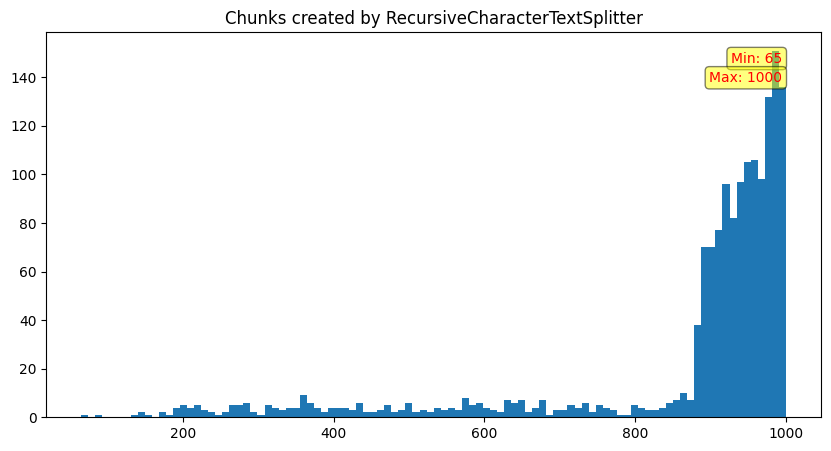

In [45]:
RCTS_chunked_documents, RCTS_len_chunks = split_documentsRCTS(doc_pages, chunk_size=1000, chunk_overlap=200)
plot_chunks(RCTS_len_chunks, "Chunks created by RecursiveCharacterTextSplitter")

## Chunking and Processing data with UNStRCUCTRED.io

- It's able to extract tables, and read within the images in pdf too. 
- It incorporated the OCR features to achieve this feat. For complex and high quality data preparation `unstrcutured.io` can be used. 
- Lets see how Unstructured.io extracts infromation from pdfs. 

In [10]:
!pdfminer.six

zsh:1: command not found: pdfminer.six


In [11]:
doc_file_paths[0]

'/Users/wenda/Documents/github/case_study_financialReport/data/docs/alphabet-2023.pdf'

In [12]:
from unstructured.partition.pdf import partition_pdf
elements = partition_pdf(doc_file_paths[0])

In [22]:
print("Numer of elements formed from the document: ", len(elements))

Numer of elements formed from the document:  4187


In [44]:
elements[100].to_dict()

{'type': 'ListItem',
 'coordinates': ((61.2, 465.85913059999996),
  (61.2, 475.85913059999996),
  (64.7, 475.85913059999996),
  (64.7, 465.85913059999996)),
 'coordinate_system': 'PixelSpace',
 'layout_width': 612.0,
 'layout_height': 792.0,
 'element_id': 'e3b0c44298fc1c149afbf4c8996fb924',
 'metadata': {'filename': 'alphabet-2023.pdf',
  'file_directory': '/Users/wenda/Documents/github/case_study_financialReport/data/docs',
  'filetype': 'application/pdf',
  'page_number': 4},
 'text': ''}

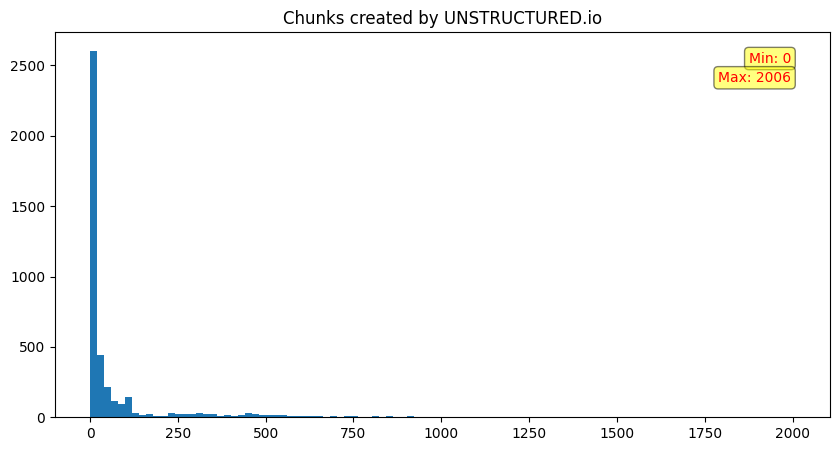

In [66]:
chunk_len = []
for element in elements:
    chunk_len.append(len(str(element)))

plot_chunks(chunk_len, "Chunks created by UNSTRUCTURED.io")

# Embeddings and Vectordb

In [54]:
import shutil

chroma_persist_directory = "processed_data"
db_path = os.path.join(chroma_persist_directory)

# Create or load Chroma Vector Database, checking is location is empty
if os.path.exists(db_path) and not os.listdir(db_path): 
    print("Creating new Chroma database...")
    vectordb = Chroma.from_documents(
            documents=RCTS_chunked_documents,
            embedding=embeddings,
            persist_directory=chroma_persist_directory
        )
    vectordb.persist()
else:
    print("Loading existing Chroma database...")
    vectordb = Chroma(persist_directory=chroma_persist_directory)
    

print("Vector database loaded successfully!")

Creating new Chroma database...
Vector database loaded successfully!


In [55]:
import re
def retrieve_merge_docs(message,vectordb, k=5):
    """
    Retrieves similar documents from a vector database, merges them into a single string, and removes extra spaces and newlines.

    Args:
        message (str): The query to search for.
        vectordb (Chroma): The Chroma vector database instance.
        k (int, optional): The number of documents to retrieve. Defaults to 5.

    Returns:
        str: The merged and cleaned document text.
    """
    docs = vectordb.similarity_search(message, k)

    # Printing document metadata (for debugging/understanding)
    print(type(docs[1].page_content))
    print(docs[1].page_content)
    print(type(docs[1].metadata))
    print(docs[1].metadata)
    

    merged_docs = " ".join([doc.page_content for doc in docs]).strip()
    merged_docs = re.sub(r'\s+', ' ', merged_docs)  # Remove extra spaces
    return merged_docs, docs

testing retrieval with message4

In [56]:
# Example Usage (assuming you have a 'vectordb' instance):
docs_str, _ = retrieve_merge_docs(message4,vectordb, 5)
print(docs_str)

<class 'dict'>
{'page': 86, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/nvidia-2023.pdf'}
<class 'str'>
Fees Billed by the Independent Registered Public Accounting Firm 
The following is a summary of fees billed by PwC for Fiscal 2023 and 2022 for audit, tax and other professional services 
during each fiscal year: 
Fiscal 2023 Fiscal 2022
Audit Fees (1)
$ 6,858,279 $ 6,762,002 
Audit Related Fees (2)
 243,400  491,100 
Tax Fees (3)
 1,189,263  708,680 
All Other Fees (4)
 17,858  12,900 
Total Fees$ 8,308,800 $ 7,974,682 
(1)For the audit of our consolidated financial statements, including business combination activities during the year, the audit of our internal control over 
financial reporting, review of our quarterly financial statements and annual reports, review of SEC registration statements and related consents, review 
of SEC filings for public debt financing and related comfort letters, and fees related to statutory audits of some of our international 

Testing LLM outputs 

In [57]:
print("For the Question: ", message4)

For the Question:  What was the Total Fees Billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA?


In [124]:
from openai import OpenAI

client = OpenAI()
response = client.chat.completions.create(model=llm_model,
                                        messages=[
                                            {"role": "system", "content": system_prompt},
                                            {"role": "user", "content": "Retrived Content: "+docs_str+"\nUser Question:"+message4}
                                            ],
                                            temperature=temperature)
print(f"Running {llm_model}...")
print(response.choices[0].message.content)

Running gpt-3.5-turbo...
New question: 

I'm sorry, but I couldn't find the information regarding the total fees billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA in the retrieved content provided.


#### Testing Reranking

In [13]:
!pip install --quiet transformers torch

In [14]:
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("colbert-ir/colbertv2.0")
model = AutoModel.from_pretrained("colbert-ir/colbertv2.0")

In [131]:
import torch

start = time.time()
scores = []

# Function to compute MaxSim
def maxsim(query_embedding, document_embedding):
    # Expand dimensions for broadcasting
    # Query: [batch_size, query_length, embedding_size] -> [batch_size, query_length, 1, embedding_size]
    # Document: [batch_size, doc_length, embedding_size] -> [batch_size, 1, doc_length, embedding_size]
    expanded_query = query_embedding.unsqueeze(2)
    expanded_doc = document_embedding.unsqueeze(1)

    # Compute cosine similarity across the embedding dimension
    sim_matrix = torch.nn.functional.cosine_similarity(expanded_query, expanded_doc, dim=-1)

    # Take the maximum similarity for each query token (across all document tokens)
    # sim_matrix shape: [batch_size, query_length, doc_length]
    max_sim_scores, _ = torch.max(sim_matrix, dim=2)

    # Average these maximum scores across all query tokens
    avg_max_sim = torch.mean(max_sim_scores, dim=1)
    return avg_max_sim

# Encode the query
query_encoding = tokenizer(message, return_tensors='pt')
query_embedding = model(**query_encoding).last_hidden_state.mean(dim=1)

_, docs = retrieve_merge_docs(message4, vectordb, 15)
# Get score for each document
for document in docs:
    document_encoding = tokenizer(document.page_content, return_tensors='pt', truncation=True, max_length=512)
    document_embedding = model(**document_encoding).last_hidden_state

    # Calculate MaxSim score
    score = maxsim(query_embedding.unsqueeze(0), document_embedding)
    scores.append({
        "score": score.item(),
        "document": document.page_content,
    })

print(f"Took {time.time() - start} seconds to re-rank documents with ColBERT.")

<class 'dict'>
{'page': 132, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/nvidia-2023.pdf'}
<class 'str'>
Report of Independent Registered Public Accounting Firm
To the Board of Directors and Shareholders of NVIDIA Corporation
Opinions on the Financial Statements and Internal Control over Financial Reporting
We have audited the accompanying consolidated balance sheets of NVIDIA Corporation and its subsidiaries (the 
“Company”) as of January 29, 2023 and January 30, 2022, and the related consolidated statements of income, 
comprehensive income, shareholders' equity and cash flows for each of the three years in the period ended January 29, 
2023, including the related notes and financial statement schedule listed in the index appearing under Item 15(a)(2) 
(collectively referred to as the “consolidated financial statements”). We also have audited the Company's internal control 
over financial reporting as of January 29, 2023, based on criteria established in Interna

In [134]:
import json
# Sort the scores by highest to lowest and print
sorted_data = sorted(scores, key=lambda x: x['score'], reverse=True)
top5_data = sorted_data[:5]
print(json.dumps(top5_data, indent=2))

[
  {
    "score": 0.5484880805015564,
    "document": "concerning independence. The AC also considered whether the provision of certain permitted non-audit services by PwC \nis compatible with PwC\u2019s independence and discussed PwC\u2019s independence with PwC. \nBased on the AC\u2019s review and discussions, the AC recommended to the Board of Directors that the audited consolidated \nfinancial statements be included in the Annual Report on Form\u00a010-K of NVIDIA for the fiscal year ended January\u00a029, 2023.\nAudit Committee\nMichael G. McCaffery, Mark L. Perry, A. Brooke Seawell, Aarti Shah and Mark A. Stevens\n69"
  },
  {
    "score": 0.5484880805015564,
    "document": "concerning independence. The AC also considered whether the provision of certain permitted non-audit services by PwC \nis compatible with PwC\u2019s independence and discussed PwC\u2019s independence with PwC. \nBased on the AC\u2019s review and discussions, the AC recommended to the Board of Directors that

### Performing prompt compression and rank relevant docs

In [144]:
!pip install accelerate
!pip install llmlingua

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
from llmlingua import PromptCompressor

llm_lingua = PromptCompressor(
    model_name="microsoft/llmlingua-2-bert-base-multilingual-cased-meetingbank",
    model_config={"revision": "main"},
    use_llmlingua2=True,
    device_map="cpu",
)

# Function definition
def compress_query_prompt(query):

    demonstration_str = query['demonstration_str']
    instruction = query['instruction']
    question = query['question']

    # 6x Compression
    compressed_prompt = llm_lingua.compress_prompt(
        demonstration_str.split("\n"), 
        instruction=instruction,
        question=question,
        target_token=500,
        rank_method="longllmlingua", 
        context_budget="+100",
        dynamic_context_compression_ratio=0.4,
        reorder_context="sort",
    )

    return json.dumps(compressed_prompt, indent=4)


/Users/wenda/anaconda3/envs/temus2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
_, docs = retrieve_merge_docs(message4, vectordb, 20)
print("Numebr of docs retrieved: ", len(docs))

<class 'dict'>
{'page': 86, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/nvidia-2023.pdf'}
<class 'str'>
Fees Billed by the Independent Registered Public Accounting Firm 
The following is a summary of fees billed by PwC for Fiscal 2023 and 2022 for audit, tax and other professional services 
during each fiscal year: 
Fiscal 2023 Fiscal 2022
Audit Fees (1)
$ 6,858,279 $ 6,762,002 
Audit Related Fees (2)
 243,400  491,100 
Tax Fees (3)
 1,189,263  708,680 
All Other Fees (4)
 17,858  12,900 
Total Fees$ 8,308,800 $ 7,974,682 
(1)For the audit of our consolidated financial statements, including business combination activities during the year, the audit of our internal control over 
financial reporting, review of our quarterly financial statements and annual reports, review of SEC registration statements and related consents, review 
of SEC filings for public debt financing and related comfort letters, and fees related to statutory audits of some of our international 